# LQR optimal control using `ldsctrlest`

This tutorial will be more comprehensive than the others, bringing together all of `cleo`'s main capabilities&mdash;electrode recording, optogenetics, and latency modeling&mdash;as well as introducing more sophisticated model-based feedback control. To achieve the latter, we will use the Python bindings to the [`ldsCtrlEst` C++ library](https://cloctools.github.io/lds-ctrl-est/).

Preamble:

In [1]:
from brian2 import ms, mm, um, second, mV, Hz, np
import brian2.only as b2
import matplotlib.pyplot as plt
import cleo

cleo.utilities.style_plots_for_docs()

# numpy faster than cython for lightweight example
b2.prefs.codegen.target = "numpy"
np.random.seed(17320222)
b2.seed(17870917)
cleo.utilities.set_seed(17991214)

cy1 = "#C500CC"
cy2 = "#df87e1"
cu1 = cleo.utilities.wavelength_to_rgb(463 * b2.nmeter)
cu2 = cleo.utilities.wavelength_to_rgb(483 * b2.nmeter)

## Network setup

For the network model we adapt an E/I network implementation [from the Neuronal Dynamics textbook](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network):

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


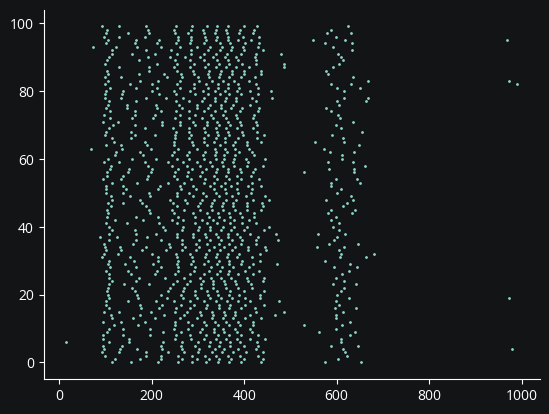

In [2]:
b2.defaultclock.dt = 0.5 * b2.ms

n_exc = 80
n_inh = int(n_exc / 4)
connection_probability = 0.1
n_ext = int(n_exc * connection_probability)
w0 = 0.1 * b2.mV  # 0.2
g = 4
w_inh = -g * w0
synaptic_delay = 1.5 * b2.ms
w_external = w0
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
tau_m = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms
thresh_rate = (firing_threshold - v_rest) / (w_external * n_ext * tau_m)
poisson_input_rate = 1 * thresh_rate
bias_current = 11 * b2.pA
# I_bias = b2.TimedArray((np.arange(20) % 2 == 0) * bias_current, dt=100 * b2.ms)

bias_ng = b2.NeuronGroup(
    1, "dI_bias/dt = -I_bias / second + bias_current*xi/sqrt(tau_m) : amp"
)

lif_dynamics = """
dv/dt = (-(v-v_rest) + Rm * (I + I_bias)) / tau_m : volt (unless refractory)
I : amp
I_bias : amp (linked)
"""

ng = b2.NeuronGroup(
    n_exc + n_inh,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
ng.I_bias = b2.linked_var(bias_ng, "I_bias")

# random v init
ng.v = (
    np.random.uniform(
        v_rest / b2.mV, high=firing_threshold / b2.mV, size=(n_exc + n_inh)
    )
    * b2.mV
)
ng_exc = ng[:n_exc]
ng_inh = ng[n_exc:]

syn = b2.Synapses(
    ng,
    model="w : volt",
    on_pre="v += w",
    delay=synaptic_delay,
)
syn.connect(p=connection_probability)
syn[f"i < {n_exc}"].w = w0
syn[f"i >= {n_exc}"].w = w_inh

external_poisson_input = b2.PoissonInput(
    target=ng,
    target_var="v",
    N=n_ext,
    rate=poisson_input_rate,
    weight=w_external,
)

rate_monitor = b2.PopulationRateMonitor(ng)
spike_monitor = b2.SpikeMonitor(ng, record=True)
# voltage_monitor = b2.StateMonitor(neurons, "v", record=idx_monitored_neurons)

net = b2.Network(
    ng,
    bias_ng,
    syn,
    external_poisson_input,
    rate_monitor,
    spike_monitor,
    # voltage_monitor,
)

runtime = 1 * b2.second
net.store()
net.run(runtime)

plt.scatter(spike_monitor.t / b2.ms, spike_monitor.i, s=1)
net.restore()

## Coordinates, stimulation, and recording

Here we assign coordinates to the neurons and configure the optogenetic intervention and recording setup:

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x [mm]', ylabel='y [mm]', zlabel='z [mm]'>)

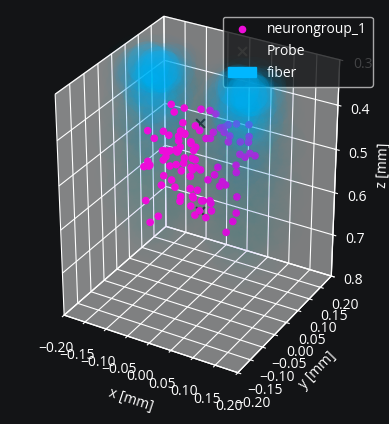

In [3]:
hor_lim = 0.1
cleo.coords.assign_coords_rand_rect_prism(
    ng, xlim=(-hor_lim, hor_lim), ylim=(-hor_lim, hor_lim), zlim=(0.4, 0.6)
)

fibers = cleo.light.Light(
    name="fiber",
    light_model=cleo.light.fiber473nm(R0=50 * um),
    coords=[(-0.1, 0, 0.3), (0.1, 0, 0.3)] * mm,
)

opsin = cleo.opto.chr2_4s()

spikes = cleo.ephys.MultiUnitSpiking(
    name="spikes",
    r_perfect_detection=40 * um,
    r_half_detection=80 * um,
)
probe = cleo.ephys.Probe(
    coords=[[0, 0, 0.4], [0, 0, 0.6]] * mm,
    signals=[spikes],
    save_history=True,
)

cleo.viz.plot(
    ng,
    colors=["xkcd:fuchsia"],
    xlim=(-0.2, 0.2),
    ylim=(-0.2, 0.2),
    zlim=(0.3, 0.8),
    devices=[probe, fibers],
    scatterargs={"alpha": 1},
    axis_scale_unit=mm,
)

Looks right. Let's set up the simulation and inject the devices:

In [4]:
sim = cleo.CLSimulator(net)
sim.inject(fibers, ng)
sim.inject(opsin, ng, Iopto_var_name="I")
sim.inject(probe, ng)

CLSimulator(io_processor=None, devices={FourStateOpsin(name='ChR2', save_history=True, on_pre='', spectrum=[(400, 0.34), (422, 0.65), (460, 0.96), (470, 1), (473, 1), (500, 0.57), (520, 0.22), (540, 0.06), (560, 0.01), (800, 1.257478763901864e-06), (844, 2.404003519224151e-06), (920, 3.5505282745464387e-06), (940, 3.6984669526525404e-06), (946, 3.6984669526525404e-06), (1000, 2.1081261630119477e-06), (1040, 8.136627295835588e-07), (1080, 2.2190801715915242e-07), (1120, 3.69846695265254e-08)], extrapolate=False, required_vars=[('Iopto', amp), ('v', volt)], g0=114. * nsiemens, gamma=0.00742, phim=2.33e+23 * (second ** -1) / (meter ** 2), k1=4.15 * khertz, k2=0.868 * khertz, p=0.833, Gf0=37.3 * hertz, kf=58.1 * hertz, Gb0=16.1 * hertz, kb=63. * hertz, q=1.94, Gd1=105. * hertz, Gd2=13.8 * hertz, Gr0=0.33 * hertz, E=0. * volt, v0=43. * mvolt, v1=17.1 * mvolt, model="\n        dC1/dt = Gd1*O1 + Gr0*C2 - Ga1*C1 : 1 (clock-driven)\n        dO1/dt = Ga1*C1 + Gb*O2 - (Gd1+Gf)*O1 : 1 (clock-drive

## Collect training data
Our goal will be to control two neuron's firing rates simultaneously.
To do this, we will use the LQR technique explained in [Bolus et al., 2021 ("State-space optimal feedback control of optogenetically driven neural activity)"](https://iopscience.iop.org/article/10.1088/1741-2552/abb89c/meta).
LQR is a model-based technique, and to fit a model of the system's dynamics, we first need training data.
We will generate training data using Gaussian random walk inputs, modulo'ed to a normal stimulation range (0-50 mW/mm²).
Here we structure our data into trials, as `ldsCtrlEst` is designed for.
$u$ represents the input and $z$ the spike output.

In [5]:
n_trials = 5
n_samp = 500
u = []
z = []
n_u = 2  # 1-dimensional input (just one optogenetic actuator)
n_z = 2  # we'll be controlling two neurons
for trial in range(n_trials):
    u_trial = 10 * np.cumsum(np.random.randn(n_u, n_samp), axis=1) % 50
    u.append(u_trial)
    z.append(np.zeros((n_z, n_samp)))

We configure the {class}`~cleo.ioproc.LatencyIOProcessor` to deliver our pre-computed stimulus and record the results, resetting after each trial:

In [6]:
from cleo.ioproc import LatencyIOProcessor


class TrainingStimIOP(LatencyIOProcessor):
    i_samp = 0
    i_trial = 0

    # here we just feed in the training inputs and record the outputs
    def process(self, state_dict, t_samp):
        i, t, z_t = state_dict["Probe"]["spikes"]
        z[self.i_trial][:, self.i_samp] = z_t[:n_z]  # just first two neurons
        out = {"fiber": u[self.i_trial][:, self.i_samp] * b2.mwatt / b2.mm2}
        self.i_samp += 1
        return out, t_samp

    # gets called with sim.reset()
    def reset(self):
        self.i_samp = 0


dt = 2 * ms
training_stim_iop = TrainingStimIOP(sample_period=dt)
sim.set_io_processor(training_stim_iop)

for i_trial in range(n_trials):
    training_stim_iop.i_trial = i_trial
    sim.run(n_samp * dt)
    sim.reset()

INFO       No numerical integration method specified for group 'syn_ChR2_neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
WARNING    'dt' is an internal variable of group 'syn_ChR2_neurongroup_1', but also exists in the run namespace with the value 2. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'syn_ChR2_neurongroup_1', but also exists in the run namespace with the value 2. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Let's plot our training data:

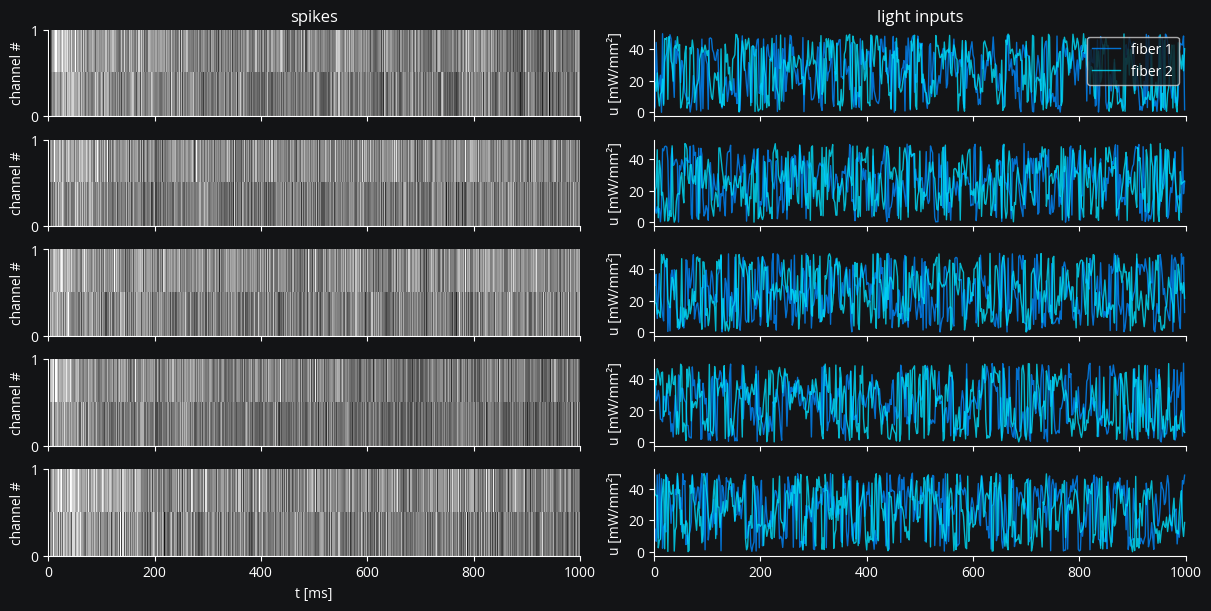

In [7]:
fig, axs = plt.subplots(
    n_trials, 2, figsize=(12, 6), layout="compressed", sharex=True, sharey="col"
)

for i, (utrial, ztrial) in enumerate(zip(u, z)):
    # Plot spiking data
    ax_spike = axs[i, 0]
    ax_spike.imshow(
        ztrial,
        aspect="auto",
        cmap="gray",
        extent=[0, (n_samp * dt) / ms, *np.arange(n_z + 1)],
        interpolation="nearest",
        zorder=0,
    )
    ax_spike.set(ylabel="channel #", yticks=range(n_z))
    if i == n_trials - 1:
        ax_spike.set(xlabel="t [ms]")

    # Plot input data
    ax_input = axs[i, 1]
    lines = ax_input.plot(
        np.arange(n_samp) * dt / ms,
        utrial.T,
        alpha=0.8,
        lw=1,
    )
    for i, ln, c in zip(range(n_u), lines, [cu1, cu2]):
        ln.set(color=c, label=f"fiber {i + 1}")
    ax_input.set(ylabel="u [mW/mm²]")
    if i == n_trials - 1:
        ax_input.set(xlabel="t [ms]")

axs[0, 1].legend()
axs[0, 0].set(title="spikes")
axs[0, 1].set(title="light inputs")
plt.show()

## Model fitting

Now we have `u` and `z` in the form we need for `ldsctrlest`'s fitting functions: `n_trial`-length lists of `n` by `n_samp` arrays. We will now fit Gaussian linear dynamical systems using the SSID algorithm. See [the documentation](https://cloctools.github.io/lds-ctrl-est/) for more detailed explanations.

In [8]:
import ldsctrlest as lds
import ldsctrlest.gaussian as glds

n_x_fit = 3  # latent dimensionality of system
n_h = 100  # size of block Hankel data matrix
u_train = lds.UniformMatrixList(u, free_dim=2)
z_train = lds.UniformMatrixList(z, free_dim=2)
ssid = glds.FitSSID(n_x_fit, n_h, dt / second, u_train, z_train)
fit, sing_vals = ssid.Run(lds.SSIDWt.kMOESP)
fit_sys_ssid = glds.System(fit)

Here we plot the singular values of the data matrix—we should see a drop at or before our chosen model order if we have a decent fit.
We also visualize impulse responses: we should see increases in firing rate for each of the fibers:

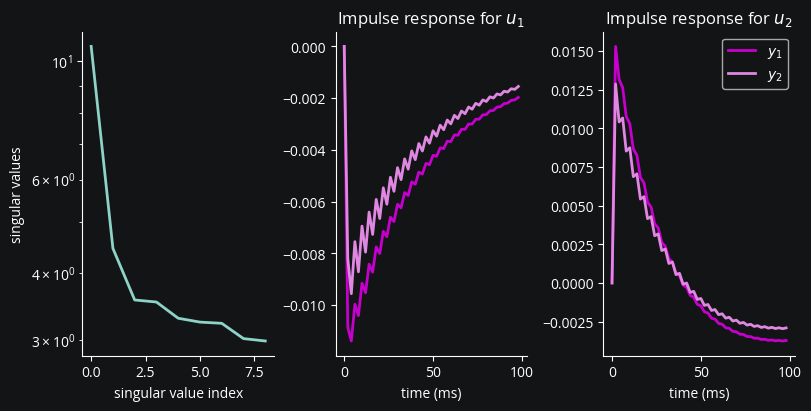

In [9]:
n_samp_imp = 50
y_imp = fit_sys_ssid.simulate_imp(n_samp_imp)
t_imp = np.arange(n_samp_imp) * dt / ms

fig, axs = plt.subplots(1, 3, figsize=(2 + n_u * 3, 4), layout="compressed")
axs[0].semilogy(sing_vals[: n_x_fit * 3], linewidth=2)
axs[0].set(ylabel="singular values", xlabel="singular value index")

for i_u in range(n_u):
    ax = axs[i_u + 1]
    lines = ax.plot(t_imp, y_imp[i_u].T, linewidth=2)
    lines[0].set_color(cy1)
    lines[1].set_color(cy2)
    ax.set(title=f"Impulse response for $u_{i_u+1}$", xlabel="time (ms)")


ax.legend(lines, ["$y_1$", "$y_2$"]);

We see a sharp drop in singular values after the first few, which justifies our model order choice.
For the impulse responses, we expect both fibers to cause transitory increases in firing rate for both electrodes.
Since we see that isn't the case for the first, let's try refining our fit with expectation-maximization (EM):

In [10]:
em = glds.FitEM(fit, u_train, z_train)
fit_em = em.Run(
    calc_dynamics=True,
    calc_Q=True,
    calc_init=True,
    calc_output=True,
    calc_measurement=True,
    max_iter=50,
    tol=1e-2,
)
fit_sys_em = glds.System(fit_em)

Iteration 1/50 ...
C_new[0]: -0.111978
d_new[0]: 8.85627
R_new[0]: 15.379
A_new[0]: 1.02137
B_new[0]: 0.0105427
Q_new[0]: 0.229825
x0_new[0]: -1.47195e-05
P0_new[0]: 1e-06
max dtheta: 5.10312

Iteration 2/50 ...
C_new[0]: -0.00158665
d_new[0]: 10.9381
R_new[0]: 15.4889
A_new[0]: 1.00248
B_new[0]: 0.00798634
Q_new[0]: 0.257583
x0_new[0]: -1.93331e-05
P0_new[0]: 1e-06
max dtheta: 5.39663

Iteration 3/50 ...
C_new[0]: 0.0543109
d_new[0]: 13.1308
R_new[0]: 15.0314
A_new[0]: 1.00098
B_new[0]: 0.00698578
Q_new[0]: 0.264213
x0_new[0]: -1.95496e-05
P0_new[0]: 1e-06
max dtheta: 35.2298

Iteration 4/50 ...
C_new[0]: 0.100015
d_new[0]: 15.9832
R_new[0]: 14.4871
A_new[0]: 0.999671
B_new[0]: 0.00636562
Q_new[0]: 0.267106
x0_new[0]: -1.90329e-05
P0_new[0]: 1e-06
max dtheta: 1.53139

Iteration 5/50 ...
C_new[0]: 0.128606
d_new[0]: 17.4668
R_new[0]: 14.2262
A_new[0]: 0.997991
B_new[0]: 0.00622277
Q_new[0]: 0.269672
x0_new[0]: -1.85481e-05
P0_new[0]: 1e-06
max dtheta: 6.88761

Iteration 6/50 ...
C_new[

7.435
R_new[0]: 12.7963
A_new[0]: 0.985964
B_new[0]: 0.00598465
Q_new[0]: 0.296914
x0_new[0]: -1.71444e-05
P0_new[0]: 1.00003e-06
max dtheta: 0.303201

Iteration 17/50 ...
C_new[0]: 0.253609
d_new[0]: 17.3217
R_new[0]: 12.6917
A_new[0]: 0.985015
B_new[0]: 0.00600984
Q_new[0]: 0.299258
x0_new[0]: -1.71001e-05
P0_new[0]: 1.00004e-06
max dtheta: 0.445072

Iteration 18/50 ...
C_new[0]: 0.261342
d_new[0]: 17.207
R_new[0]: 12.5905
A_new[0]: 0.984102
B_new[0]: 0.00605776
Q_new[0]: 0.30158
x0_new[0]: -1.70617e-05
P0_new[0]: 1.00004e-06
max dtheta: 0.815542

Iteration 19/50 ...
C_new[0]: 0.26879
d_new[0]: 17.0917
R_new[0]: 12.4929
A_new[0]: 0.983224
B_new[0]: 0.0061291
Q_new[0]: 0.30388
x0_new[0]: -1.70288e-05
P0_new[0]: 1.00005e-06
max dtheta: 4.47334

Iteration 20/50 ...
C_new[0]: 0.275956
d_new[0]: 16.9768
R_new[0]: 12.3989
A_new[0]: 0.982381
B_new[0]: 0.00622397
Q_new[0]: 0.306158
x0_new[0]: -1.70009e-05
P0_new[0]: 1.00006e-06
max dtheta: 2.71289

Iteration 21/50 ...
C_new[0]: 0.282845
d_ne

We'll plot impulse responses again:

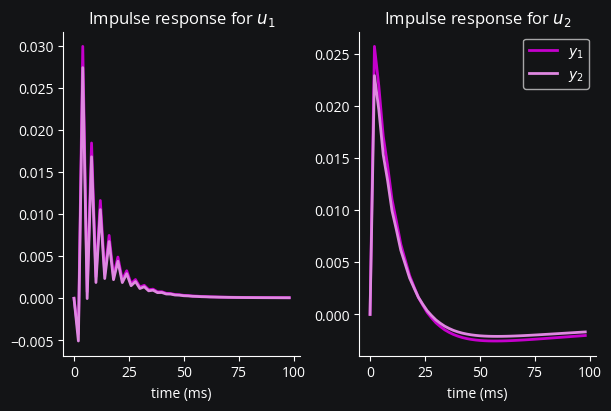

In [11]:
y_imp = fit_sys_em.simulate_imp(n_samp_imp)

fig, axs = plt.subplots(1, 2, figsize=(3 * n_u, 4), layout="compressed")
for i_u in range(n_u):
    ax = axs[i_u]
    lines = ax.plot(t_imp, y_imp[i_u].T, linewidth=2)
    lines[0].set_color(cy1)
    lines[1].set_color(cy2)
    ax.set(title=f"Impulse response for $u_{i_u+1}$", xlabel="time (ms)")

ax.legend(lines, ["$y_1$", "$y_2$"]);

Looking better.
Since we can't visualize singular values, let's compare the two fits with percent explained variance: 

In [12]:
z_arr = np.array(z)


def pct_exp_var(sys, nstep=1):
    x_filt, x_pred, y_pred = sys.nstep_pred_block(u_train, z_train, nstep)
    y_pred = np.array(y_pred)
    assert y_pred.shape == z_arr[:, :, nstep:].shape, y_pred.shape
    corrcoef_mat = np.corrcoef(z_arr[:, :, nstep:].flatten(), y_pred[:, :, :].flatten())
    return corrcoef_mat[0, 1] ** 2


print("SSID r²:", pct_exp_var(fit_sys_ssid))
print("EM r²:", pct_exp_var(fit_sys_em))

SSID r²: 0.04383360173764044
EM r²: 0.13481170536206497


As we suspected from the impulse responses, the EM-refined fit is much better.

## LQR optimal controller design

We now use the fit parameters to create the controller system and set additional parameters. The feedback gain, $ K_c $, is especially important, determining how the controller responds to the current "error"&mdash;the difference between where the system is (estimated to be) now and where we want it to be. The field of optimal control deals with how to design the controller so as to minimize a cost function reflecting what we care about.

With a linear system (obtained from the fitting procedure above) and quadratic per-timestep cost function $L$ penalizing distance from the reference $x^*$ and the input $u$

$$ L = \frac{1}{2} (x - x^*)^T Q (x - x^*) + \frac{1}{2} u^T R u $$

we can use the closed-form optimal solution called the Linear Quadratic Regulator (LQR).

$$ K = (R + B^T P B)^{-1}(B^T P A) \quad\quad u = -Kx$$

The $P$ matrix is obtained by numerically solving the discrete algebraic Riccati equation:

$$
P=A^{T} P A-\left(A^{T} P B\right)\left(R+B^{T} P B\right)^{-1}\left(B^{T} P A\right)+Q
$$

In [13]:
# upper and lower bounds on control signal (optic fiber light intensity)
u_lb = 0  # mW/mm2
u_ub = 75  # mW/mm2
controller = glds.Controller(fit_sys_em, u_lb, u_ub)
# careful not to use this anymore since controller made a copy
del fit_sys_em

In [14]:
from scipy.linalg import solve_discrete_are

# cost matrices
# Q reflects how much we care about state error
# we use C'C since we really care about output error, not latent state
Q_cost = controller.sys.C.T @ controller.sys.C
R_cost = 1e-4 * np.eye(n_u)  # reflects how much we care about minimizing the stimulus
A, B = controller.sys.A, controller.sys.B
P = solve_discrete_are(A, B, Q_cost, R_cost)
controller.Kc = np.linalg.inv(R_cost + B.T @ P @ B) @ (B.T @ P @ A)
print(controller)
print("For controlled system dynamics A - BK:")
print("eigvals:", np.linalg.eigvals(A - B @ controller.Kc))
print("magnitude of eigvals:", np.abs(np.linalg.eigvals(A - B @ controller.Kc)))


 ********** SYSTEM ********** 
x: 
  -27.0134
  -14.3165
   -2.7832

P: 
   11.5611    4.4943    0.0430
    4.4943    2.4885    0.3463
    0.0430    0.3463   11.7346

A: 
   0.9613   0.0973   0.0392
   0.0294   0.8609   0.0877
  -0.0127   0.0470  -0.7268

B: 
   0.0153   0.0056
  -0.0133  -0.0344
  -0.0591  -0.0027

g: 
   1.0000
   1.0000

m: 
        0
        0
        0

Q: 
   0.3636   0.1986   1.4124
   0.1986   0.2662   1.3413
   1.4124   1.3413   8.5356

Q_m: 
   1.0000e-06            0            0
            0   1.0000e-06            0
            0            0   1.0000e-06

d: 
   15.0531
   13.3232

C: 
   0.3976  -0.7091   0.3339
   0.3415  -0.6354   0.3171

y: 
   13.5351
   12.3129

R: 
   10.7560    1.1165
    1.1165   10.7561

g_design :    1.0000
   1.0000

u_lb : 0
u_ub : 75

For controlled system dynamics A - BK:
eigvals: [ 0.98651763  0.06694736 -0.2470999 ]
magnitude of eigvals: [0.98651763 0.06694736 0.2470999 ]


We now configure the `IOProcessor` to use our controller:

In [15]:
y_ref = np.mean(z) * 0.75  # target rate per timebin


class CtrlLoop(LatencyIOProcessor):
    def __init__(self, sample_period, controller):
        super().__init__(sample_period)
        self.controller = controller
        self.sys = controller.sys
        self.do_control = False  # allows us to turn on and off control

        # for post hoc visualization/analysis:
        self.x_hat = np.empty((n_x_fit, 0))
        self.y_hat = np.empty((n_z, 0))
        self.z = np.empty((n_z, 0))

    def process(self, state_dict, t_samp):
        i, t, z_t = state_dict["Probe"]["spikes"]
        z_t = z_t[:n_z].reshape((-1, 1))  # just first n_z neurons
        self.controller.y_ref = np.ones((n_z, 1)) * y_ref

        u_t = self.controller.ControlOutputReference(z_t, do_control=self.do_control)
        out = {fibers.name: u_t.squeeze() * b2.mwatt / b2.mm2}

        # record variables from this timestep
        self.y_hat = np.hstack([self.y_hat, self.sys.y])
        self.x_hat = np.hstack([self.x_hat, self.sys.x])
        self.z = np.hstack((self.z, z_t))

        return out, t_samp + 3 * ms  # 3 ms delay


ctrl_loop = CtrlLoop(sample_period=dt, controller=controller)

## Run the experiment

We'll now run the simulation with and without control to compare.

In [16]:
sim.set_io_processor(ctrl_loop)
sim.reset()  # only needed when rerunning
T0 = 200 * ms
sim.run(T0)

ctrl_loop.do_control = True
T1 = 1000 * ms
sim.run(T1)

Now we plot the results to see how well the controller was able to match the desired firing rate:

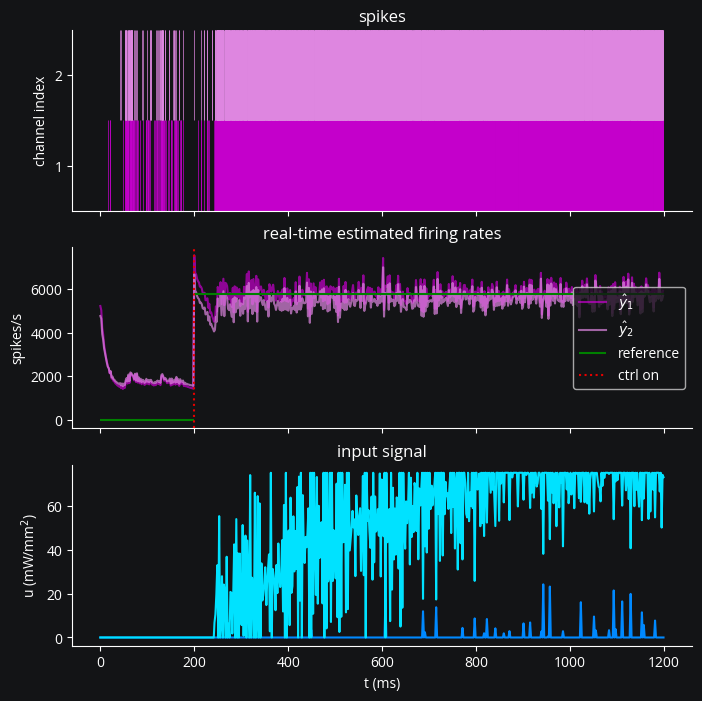

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
spikes1 = spikes.t[spikes.i == 0] / ms
spikes2 = spikes.t[spikes.i == 1] / ms
ax1.eventplot([spikes1, spikes2], lineoffsets=[1, 2], colors=[cy1, cy2], lw=0.5)
ax1.set(ylabel="channel index", ylim=(0.5, 2.5), title="spikes", yticks=[1, 2])
ax2.set(ylabel="spikes/s", title="real-time estimated firing rates")
ax2.plot(
    ctrl_loop.t_samp / ms,
    ctrl_loop.y_hat[0] / dt,
    c=cy1,
    alpha=0.7,
    label="$\\hat{y}_1$",
)
ax2.plot(
    ctrl_loop.t_samp / ms,
    ctrl_loop.y_hat[1] / dt,
    c=cy2,
    alpha=0.7,
    label="$\\hat{y}_2$",
)
ax2.hlines((y_ref / dt) / Hz, T0 / ms, (T0 + T1) / ms, color="green", label="reference")
ax2.hlines(0, 0, T0 / ms, color="green")
ax2.axvline(T0 / ms, c="xkcd:red", linestyle=":", label="ctrl on")
ax2.legend(loc="right")
ax3.plot(fibers.t / b2.ms, fibers.irradiance_[:, 0], c=cu1)
ax3.plot(fibers.t / b2.ms, fibers.irradiance_[:, 1], c=cu2)
ax3.set(xlabel="t (ms)", ylabel="u (mW/mm$^2$)", title="input signal");

Looks all right, but in addition to the system's estimated firing rate let's count the spikes over the control period to see how well we hit the target on average:

In [18]:
i_baseline = ctrl_loop.t_samp < T0
i_static = (ctrl_loop.t_samp >= T0) & (ctrl_loop.t_samp < T0 + T1)
print("Results (spikes/second):")
print("baseline =", np.sum(ctrl_loop.z[:, i_baseline], axis=1) / T0)
print("target =", y_ref / dt)
print(
    "lqr achieved =",
    (np.sum(ctrl_loop.z[:, i_static], axis=1) / T1).round(1),
)

Results (spikes/second):
baseline = [0.425 0.35 ] kHz
target = 5.742825 kHz
lqr achieved = [5.606 5.053] kHz


We can see that the system consistently underestimates the true firing rate.
And as we could expect, we weren't able to maintain the target firing rate with both neurons simultaneously since one was exposed to more light than the other. However, the controller was able to achieve something. See the appendix for how we can avoid overshooting with both neurons, which should be avoidable.

## Conclusion
As a recap, in this tutorial we've seen how to:
- inject optogenetic stimulation into an existing Brian network
- inject an electrode into an existing Brian network to record spikes
- generate training data and fit a Gaussian linear dynamical system to the spiking output using `ldsctrlest`
- configure an `ldsctrlest` LQR controller based on that linear system and design optimal gains
- use that controller in running a complete simulated feedback control experiment

## Appendix

### Adaptive control

ldsCtrlEst also provides an *adaptive* variation on LQR, capable of inferring state beyond our static, linear model and thus able to account for unmodeled disturbances and noise.
Let's see how it compares:

In [19]:
controller.sys.do_adapt_m = True  # enable adaptive disturbance estimation
# set covariance for the disturbance state μ
# larger values mean the system more readily ascribes changes to unmodeled disturbance
controller.sys.Q_m = 1e-2 * np.eye(n_x_fit)
controller.control_type = lds.kControlTypeAdaptM  # enable adaptive control

In [20]:
ctrl_loop.sys.do_adapt_m = True
T2 = T1
sim.run(T2)
T = T0 + T1 + T2

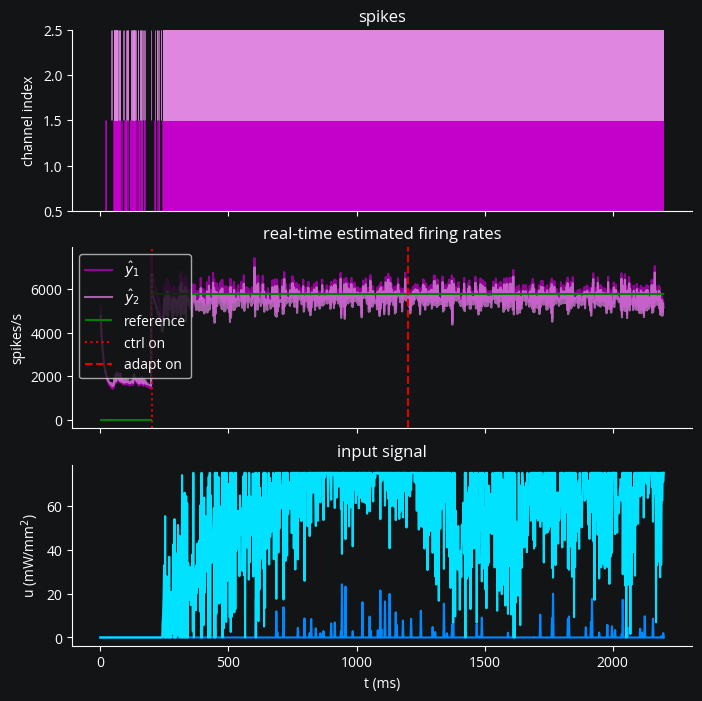

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
spikes1 = spikes.t[spikes.i == 0] / ms
spikes2 = spikes.t[spikes.i == 1] / ms
ax1.eventplot([spikes1, spikes2], lineoffsets=[1, 2], colors=[cy1, cy2], lw=0.5)
ax1.set(ylabel="channel index", ylim=(0.5, 2.5), title="spikes")
ax2.set(ylabel="spikes/s", title="real-time estimated firing rates")
ax2.plot(
    ctrl_loop.t_samp / ms,
    ctrl_loop.y_hat[0] / dt,
    c=cy1,
    alpha=0.7,
    label="$\\hat{y}_1$",
)
ax2.plot(
    ctrl_loop.t_samp / ms,
    ctrl_loop.y_hat[1] / dt,
    c=cy2,
    alpha=0.7,
    label="$\\hat{y}_2$",
)
ax2.hlines(y_ref / Hz / dt, T0 / ms, T / ms, color="green", label="reference")
ax2.hlines(0, 0, T0 / ms, color="green")
ax2.axvline(T0 / ms, c="xkcd:red", linestyle=":", label="ctrl on")
ax2.axvline((T0 + T1) / ms, c="xkcd:red", linestyle="--", label="adapt on")
ax2.legend(loc="upper left")
ax3.plot(fibers.t / b2.ms, fibers.irradiance_[:, 0], c=cu1)
ax3.plot(fibers.t / b2.ms, fibers.irradiance_[:, 1], c=cu2)
ax3.set(xlabel="t (ms)", ylabel="u (mW/mm$^2$)", title="input signal");

We can see the effect most easily in the input signal, which has much more variation now. Let's confirm that the firing rates were better balanced around the target:

In [22]:
print("Results (spikes/second):")
i_baseline = ctrl_loop.t_samp < T0
print("baseline =", np.sum(ctrl_loop.z[:, i_baseline], axis=1) / T0)
print("target =", y_ref / dt)
i_static = (ctrl_loop.t_samp >= T0) & (ctrl_loop.t_samp < T0 + T1)
print(
    "static achieved =",
    (np.sum(ctrl_loop.z[:, i_static], axis=1) / T1).round(1),
)
i_adapt = (ctrl_loop.t_samp >= T0 + T1) & (ctrl_loop.t_samp < T)
print(
    "adaptive achieved =",
    (np.sum(ctrl_loop.z[:, i_adapt], axis=1) / T2).round(1),
)

Results (spikes/second):
baseline = [0.425 0.35 ] kHz
target = 5.742825 kHz
static achieved = [5.606 5.053] kHz
adaptive achieved = [5.741 5.513] kHz


That looks better. Adaptive control achieves a balance between the two neurons, as we would expect.

### Post-hoc firing rate estimate

To see if the system's online estimation of firing rates is reasonable, we compute a Gaussian-smoothed version with a 25 ms standard deviation:

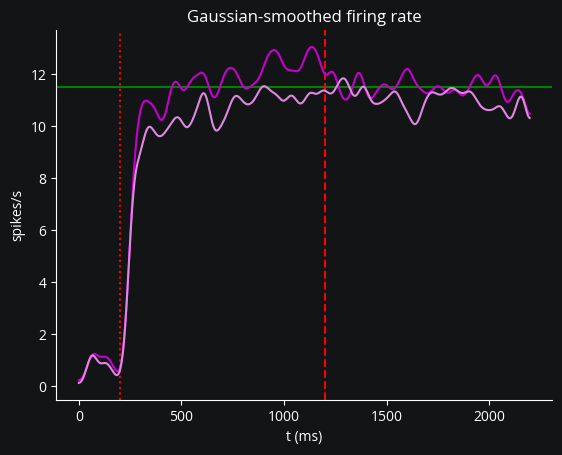

In [23]:
from scipy.ndimage import gaussian_filter1d

win_len = 25 * ms / dt
smoothed = gaussian_filter1d(ctrl_loop.z, sigma=win_len, axis=1)
plt.axhline(y_ref, c="g")
plt.axvline(T0 / ms, c="r", ls=":")
plt.axvline((T0 + T1) / ms, c="r", ls="--")
plt.xlabel("t (ms)")
plt.ylabel("spikes/s")
plt.title("Gaussian-smoothed firing rate")
plt.plot(ctrl_loop.t_samp / ms, smoothed[0], c=cy1)
plt.plot(ctrl_loop.t_samp / ms, smoothed[1], c=cy2);